# Quantum Fusion model

This notebook designs a quantum fusion model, designed to efficiently integrate the eextracted features from two classical neural network models to produce enhanced predictions. The proposed model strategically integrates 3D-CNNs and SG-CNNs to leverage their respective strengths in processing diverse facets of the training data. 
The simulation results presented here will demonstrate the superior performance of the quantum fusion model relative to state-of-the-art classical models. Particularly, the proposed model achieves a 6\% improvement in the prediction accuracy, and exhibits faster, smoother, and more stable convergence, thereby boosting its generalization capacity.

In [2]:
#to improve run time and prevent displaying warning errors which can be ignored
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from ingenii_quantum.hybrid_networks.layers import QuantumFCLayer
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import array, matmul

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from scipy.stats import *

## Problem setting: Binding affinity predictions

In the field of drug discovery, it is imperative to identify proteins that are instrumental in the cascade of molecular interactions leading to a specific disease. Upon the identification of such a target protein, a list of prospective drug candidates is generated. These candidates, often described as small molecules or compounds termed **ligands**, have the potential to modulate the target protein's activity through binding interactions. Ideal ligands are chosen based on their high binding affinity to the target protein, coupled with minimal off-target interactions with other proteins. However, quantifying such binding affinities is a resource-intensive endeavor, both in terms of time and financial investment. This is particularly true considering that the initial screening process often encompasses thousands of compounds

The transition from conventional laboratory methods to computer-aided design has markedly improved the efficiency and accuracy of drug discovery and binding affinity prediction.  Quantum machine learning  models, in particular, are well-suited to manage the challenges of exponentially increasing data dimensionality, often outperforming traditional ML models under specific conditions. Taken together, these technological advancements make QML and hybrid quantum-classical models highly promising for navigating the complex, high-dimensional challenges intrinsic to drug discovery.

The main contribution of this notebook is the development of a novel quantum fusion model aimed at enhancing the binding affinity predictions in drug discovery. 

To demonstrate the power of this approach, the first step is to load the training, valiudation and test data.
The data in this case is the extracted features from the 3D CNN (6 features) and the ones from the Spatial Graph CNN (10 features), resulting in a vector of 16 features.

In [4]:
# TRAINING
# Load features
fc_6_train=np.array(np.load('data/refined_train_fc6.npy'))
fc_10_train=np.array(np.load('data/refined_train_fc10.npy'))
# Concatenate features
fc_16_train = np.concatenate((fc_6_train, fc_10_train), axis=1)

# Load prediction
y_vals_train = np.genfromtxt("data/refined_train.csv", dtype=float, delimiter=',', names=True) 
y_train = np.array([ys[1] for ys in y_vals_train])
y_classical_train = np.array([ys[2] for ys in y_vals_train])
print('Number of samples training: ', y_train.shape[0], ' Features size: ', fc_16_train.shape[1])

# VALIDATION
# Load features
fc_6_val=np.array(np.load('data/refined_val_fc6.npy'))
fc_10_val=np.array(np.load('data/refined_val_fc10.npy'))
# Concatenate features
fc_16_val = np.concatenate((fc_6_val, fc_10_val), axis=1)

# Load prediction
y_vals_val = np.genfromtxt("data/refined_val.csv", dtype=float, delimiter=',', names=True) 
y_val = np.array([ys[1] for ys in y_vals_val])
y_classical_val = np.array([ys[2] for ys in y_vals_val])
print('Number of samples validation: ', y_val.shape[0], ' Features size: ', fc_16_val.shape[1])


# TEST
# Load features
fc_6_test=np.array(np.load('data/core_test_fc6.npy'))
fc_10_test=np.array(np.load('data/core_test_fc10.npy'))
# Concatenate features
fc_16_test = np.concatenate((fc_6_test, fc_10_test), axis=1)

# Load prediction
y_vals_test = np.genfromtxt("data/core_test.csv", dtype=float, delimiter=',', names=True) 
y_test = np.array([ys[1] for ys in y_vals_test])
y_classical_test = np.array([ys[2] for ys in y_vals_test])
print('Number of samples test: ', y_test.shape[0], ' Features size: ', fc_16_test.shape[1])

Number of samples training:  4779  Features size:  16
Number of samples validation:  537  Features size:  16
Number of samples test:  285  Features size:  16


## Scale data

We will scale the data to the [0,1] domain so that it is suitable for the quantum neural network with amplitude encoding.

In [5]:
#model parameters using aplitude encoding
nqbits = 4
length = 2**nqbits

# Training data
X_train = np.array(fc_16_train)
# Scale y values
scaler = MinMaxScaler((0,1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1))
# Validation data
X_val = np.array(fc_16_val)
y_val_scaled = scaler.transform(y_val.reshape(-1,1))
# Test data
X_test = np.array(fc_16_test)
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

## Quantum Neural Network

We will use Ingenii's library to design a quantum neural network to fuse the features from the two CNNs. Since our input data has size 16, we will use amplitude encoding to reduce the number of qubits needed from the neural network. We will use the first option of ansatz, which consists of a set of strongly entangling layers. The depth of the neural network is a hyperparameter that we can tune. In this example, we will use a depth of 10 layers.

## Define quantum layer

We define the quantum layer with Igenii's library. We will use Keras to train the hybridd model.

In [7]:
obs = ['ZIII','IZII','IIZI', 'IIIZ'] # The observables will be the expected value of the Z operators in each qubit
input_size= 16
n_layers = 10
# Initializing the class
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=n_layers, encoding='amplitude',
    ansatz=1, observables=obs, backend='default.qubit')

# Create the quantum layer
qnn_layer = qnn.create_layer(type_layer='keras')

# We test the prediction of the quantum layer
x = tf.random.uniform((2, input_size))
qnn_layer(x)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[ 0.06670204,  0.08001339, -0.24033967,  0.1829469 ],
       [-0.2967231 ,  0.49833736,  0.05364829,  0.02346145]])>

## Define the whole model

We add a classical dense layer to output the final prediction. The ReLu activation function is used. We compile the resulting model with Adam optimizer and a learning rate of $\eta=0.002$.

In [9]:
# Define classical layer
clayer = tf.keras.layers.Dense(1, activation="relu")

# Specify inputs
inputs = tf.keras.Input(shape=(2**nqbits,))
x = qnn_layer(inputs)
outputs = clayer(x)
# Create Keras model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
# Compile model with Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(opt, loss='mse')
# Print the summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 4)                 120       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


Notice that the model has 125 training parameters, including 120 quantum parameters.

## Train the neural network

Epoch 1/6
44/44 [==============================] - 2788s 63s/step - loss: 0.1397 - val_loss: 0.0471
Epoch 2/6
44/44 [==============================] - 2740s 62s/step - loss: 0.0390 - val_loss: 0.0221
Epoch 3/6
44/44 [==============================] - 2618s 60s/step - loss: 0.0233 - val_loss: 0.0187
Epoch 4/6
44/44 [==============================] - 2579s 59s/step - loss: 0.0194 - val_loss: 0.0171
Epoch 5/6
44/44 [==============================] - 2601s 59s/step - loss: 0.0177 - val_loss: 0.0180
Epoch 6/6
44/44 [==============================] - 2696s 61s/step - loss: 0.0174 - val_loss: 0.0156


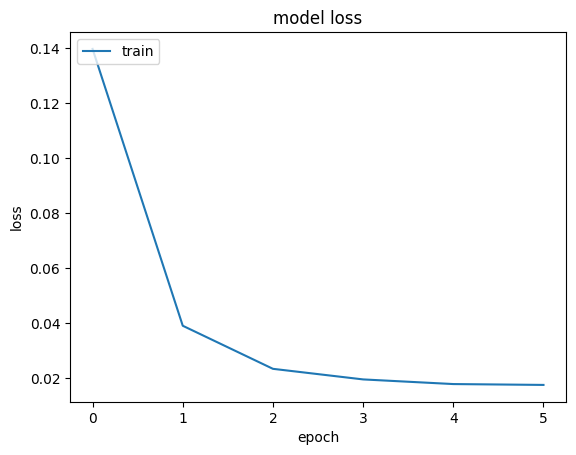

In [10]:
history = model.fit(X_train, y_train_scaled,validation_split=0.1, epochs=6,batch_size=100)


# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()



## Test the model

Now we test the model's accuracy and compare it with the classical counterpart.

In [12]:
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
print('QUANTUM FUSION')
print('Test MSE is', mean_squared_error(y_test,y_test_pred))
print('Test MAE is', mean_absolute_error(y_test,y_test_pred))
print('Test R2 is', r2_score(y_test,y_test_pred))
print('Test spearman is', spearmanr(y_test,y_test_pred))

print('\nCLASSICAL FUSION')
print('Test MSE is', mean_squared_error(y_test,y_classical_test))
print('Test MAE is', mean_absolute_error(y_test,y_classical_test))
print('Test R2 is', r2_score(y_test,y_classical_test))
print('Test spearman is', spearmanr(y_test,y_classical_test))

9/9 [==============================] - 65s 7s/step
QUANTUM FUSION
Test MSE is 1.8430677415839514
Test MAE is 1.1092326076574492
Test R2 is 0.6087863709820007
Test spearman is SignificanceResult(statistic=0.8071939383234915, pvalue=9.519729280749052e-67)

CLASSICAL FUSION
Test MSE is 2.8713729697868864
Test MAE is 1.3075838007017546
Test R2 is 0.390516032357484
Test spearman is SignificanceResult(statistic=0.6129917162900452, pvalue=8.473775644213916e-31)


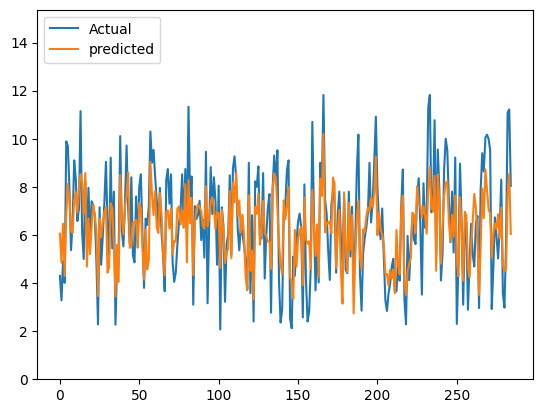

In [13]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.ylim(0, np.max(y_test)*1.3)
plt.legend(['Actual','predicted'], loc='upper left')

## Save model

We save the keras model so that we can reuse it later.

In [14]:
model_weights = model.get_weights()
qnode_config = model.get_layer(index=1).get_config()
qnode_config['input_shape'] = (2**nqbits,)

In [15]:
import pickle
with open('saved_models/quantum_fusion_weights.pickle' , 'wb') as f:
    pickle.dump(model_weights,f)

with open('saved_models/quantum_fusion_config.pickle' , 'wb') as f:
    pickle.dump(qnode_config,f)

## Load model

In [16]:
import pickle
with open('saved_models/quantum_fusion_weights.pickle' , 'rb') as f:
    model_weights = pickle.load(f)

with open('saved_models/quantum_fusion_config.pickle' , 'rb') as f:
    qnode_config = pickle.load(f)

In [17]:
obs = ['ZIII','IZII','IIZI', 'IIIZ'] # The observables will be the expected value of the Z operators in each qubit
input_size= 16
n_layers = 10
# Initializing the class
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=n_layers, encoding='amplitude',
    ansatz=1, observables=obs, backend='default.qubit')

# Create the quantum layer
qnn_layer = qnn.create_layer(type_layer='keras')

# BUILD qlayer
qnn_layer.build_from_config( qnode_config)
clayer = tf.keras.layers.Dense(1, activation="relu")

inputs = tf.keras.Input(shape=(2**nqbits,))
x = qnn_layer(inputs)
outputs = clayer(x)
model_loaded = tf.keras.Model(inputs=inputs, outputs=outputs)

# Load model weights
model_loaded.set_weights(model_weights)

In [18]:
model_loaded.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 4)                 120       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________
